In [1]:
import datetime
import numpy as np
import pandas_datareader as pdr
import esig
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import base
from utils import tosig
from utils.leadlag import leadlag
from rough_bergomi import rough_bergomi

from importlib import reload
import cvae_keras
reload(cvae_keras)
import cvae_tfp
reload(cvae_tfp)

import matplotlib.pyplot as plt

## Data processing

In [14]:
# # S&P 500
# data = pdr.get_data_yahoo("^GSPC", datetime.date(2000, 1, 1), datetime.date(2019, 1, 1))["Close"]
# windows = []
# for _, window in data.resample('M'):
#     values = window.values
#     path = leadlag(values)
#     windows.append(path)

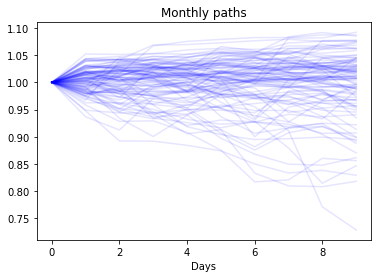

In [15]:
# Actually for rough_bergomi model, conditional VAE does no help because the cond are independent

# rough_bergomi
params = {
            "M": 100,
            "H": 0.14,
            "rho": -0.85,
            "xi0": 0.1,
            "nu": 1.5,
            "S0": 1.
          }

params2 = {
            "M": 100,
            "H": 0.14,
            "rho": -0.85,
            "xi0": 0.2,
            "nu": 1,
            "S0": 1.
          }

def _load_rough_bergomi(params, freq, test_use = False):
    grid_points_dict = {"M": 28, "W": 10, "Y": 252}
    grid_points = grid_points_dict[freq]
    params["T"] = grid_points / grid_points_dict["Y"]
    paths = rough_bergomi(grid_points, **params)
    if test_use:
        windows = paths
    else:   
        windows = [leadlag(path) for path in paths]
    return windows

windows = _load_rough_bergomi(params, 'W')

for path in windows:
    returns = path[::2, 1] / path[0, 1]
    plt.plot(returns, "b", alpha=0.1)

plt.title("Monthly paths")
plt.xlabel("Days")
plt.show()

In [16]:
windows_aug = _load_rough_bergomi(params, 'W', True)
helper = np.tile(np.arange(10)/10, [100,1])
windows = np.concatenate([helper[:,:,None], windows_aug[:,:,None]],axis = -1)

## Log-signature computing

In [17]:
order = 4
def _logsig(path):
    return esig.tosig.stream2logsig(path, order)
def _sig(path):
    return esig.tosig.stream2sig(path, order)

train_windows = _load_rough_bergomi(params, 'M')
train_logsig = np.array([_logsig(path) for path in tqdm(train_windows, desc="Computing log-signatures")])
train_sig = np.array([_sig(path) for path in tqdm(train_windows, desc="Computing signatures")])

test_windows = _load_rough_bergomi(params, 'M')
test_logsig = np.array([_logsig(path) for path in tqdm(test_windows, desc="Computing log-signatures")])
test_sig = np.array([_sig(path) for path in tqdm(test_windows, desc="Computing signatures")])

scaler_logsig = MinMaxScaler(feature_range=(0.00001, 0.99999))
logsig_transformed = scaler_logsig.fit_transform(train_logsig)

scaler_sig = MinMaxScaler(feature_range=(0.00001, 0.99999))
sig_transformed = scaler_sig.fit_transform(train_sig)

data = logsig_transformed[1:]   # 1 week forecasting 1 week 
data_cond = logsig_transformed[:-1] 
scaler = scaler_logsig

# data = sig_transformed[1:]   # 1 week forecasting 1 week 
# data_cond = sig_transformed[:-1] 
# scaler = scaler_sig

## CVAE

In [18]:
# Standard normal (tfp)
reload(cvae_tfp)
sample_dim = data.shape[0]
data_dim = data.shape[-1]
cond_dim = data_cond.shape[-1]
latent_dim = 8
hidden_dim = 50
weight = 0.003

x_input = [data, data_cond]
encoder = cvae_tfp.Encoder(data_dim, cond_dim, latent_dim, hidden_dim)
sampler = cvae_tfp.NormalSampler(latent_dim)
encodersampler = cvae_tfp.EncoderSampler(encoder,sampler)
decoder = cvae_tfp.Decoder(data_dim, cond_dim, latent_dim, hidden_dim)
model_normal = cvae_tfp.CVAE_bergomi(data_dim, cond_dim, latent_dim, hidden_dim, weight, decoder, encodersampler, False)
model_normal.compile(optimizer='adam', loss=cvae_tfp.zero_error)
model_normal.fit(x = x_input, y = data, epochs=10000,batch_size=sample_dim, verbose = True)

normalised_generated1 = model_normal.generate(data_cond)

Epoch 1/10000
1/1 [==============================] - 1s 974ms/step - loss: 1.2108
Epoch 2/10000
1/1 [==============================] - 0s 12ms/step - loss: 1.1231
Epoch 3/10000
1/1 [==============================] - 0s 3ms/step - loss: 1.1252
Epoch 4/10000
1/1 [==============================] - 0s 2ms/step - loss: 1.0036
Epoch 5/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.9609
Epoch 6/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.9082
Epoch 7/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.8345
Epoch 8/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.7893
Epoch 9/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.7431
Epoch 10/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.6918
Epoch 11/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.6379
Epoch 12/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.5977
Epoch 13/10000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 0.1447
Epoch 103/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1459
Epoch 104/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1475
Epoch 105/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1471
Epoch 106/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1444
Epoch 107/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1541
Epoch 108/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1456
Epoch 109/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1392
Epoch 110/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1408
Epoch 111/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1488
Epoch 112/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1465
Epoch 113/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1440
Epoch 114/10000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.1209
Epoch 203/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0918
Epoch 204/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0938
Epoch 205/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1005
Epoch 206/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0994
Epoch 207/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1007
Epoch 208/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0934
Epoch 209/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1078
Epoch 210/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1001
Epoch 211/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0934
Epoch 212/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0859
Epoch 213/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0893
Epoch 214/10000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.0533
Epoch 303/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0558
Epoch 304/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0508
Epoch 305/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0517
Epoch 306/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0531
Epoch 307/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0539
Epoch 308/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0560
Epoch 309/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0495
Epoch 310/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0515
Epoch 311/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0542
Epoch 312/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0535
Epoch 313/10000
1/1 [==============================] - 0s 995us/step - loss: 0.0510
Epoch 314/10000
1/1 [=========

1/1 [==============================] - 0s 2ms/step - loss: 0.0370
Epoch 403/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0377
Epoch 404/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0387
Epoch 405/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0393
Epoch 406/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0362
Epoch 407/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0370
Epoch 408/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0365
Epoch 409/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0378
Epoch 410/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0370
Epoch 411/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0413
Epoch 412/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0369
Epoch 413/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0360
Epoch 414/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0306
Epoch 503/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0339
Epoch 504/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0306
Epoch 505/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0324
Epoch 506/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0334
Epoch 507/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0308
Epoch 508/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0337
Epoch 509/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0329
Epoch 510/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0305
Epoch 511/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0325
Epoch 512/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0322
Epoch 513/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0303
Epoch 514/10000
1/1 [===========

Epoch 602/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0269
Epoch 603/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0278
Epoch 604/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0276
Epoch 605/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0268
Epoch 606/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0269
Epoch 607/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0276
Epoch 608/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0275
Epoch 609/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0268
Epoch 610/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0289
Epoch 611/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0277
Epoch 612/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0289
Epoch 613/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0285
Epoch 614/10000


1/1 [==============================] - 0s 2ms/step - loss: 0.0267
Epoch 702/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0266
Epoch 703/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0246
Epoch 704/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0248
Epoch 705/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0244
Epoch 706/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0253
Epoch 707/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0255
Epoch 708/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0255
Epoch 709/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0246
Epoch 710/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0252
Epoch 711/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0264
Epoch 712/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0247
Epoch 713/10000
1/1 [=========

1/1 [==============================] - 0s 3ms/step - loss: 0.0245
Epoch 802/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0254
Epoch 803/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0234
Epoch 804/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0232
Epoch 805/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0244
Epoch 806/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0232
Epoch 807/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0234
Epoch 808/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0253
Epoch 809/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0239
Epoch 810/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0274
Epoch 811/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0268
Epoch 812/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0230
Epoch 813/10000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.0218
Epoch 902/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0209
Epoch 903/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0237
Epoch 904/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0228
Epoch 905/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0231
Epoch 906/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0252
Epoch 907/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0231
Epoch 908/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0254
Epoch 909/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0228
Epoch 910/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0232
Epoch 911/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0225
Epoch 912/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0227
Epoch 913/10000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.0240
Epoch 1002/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0218
Epoch 1003/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0225
Epoch 1004/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0221
Epoch 1005/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0212
Epoch 1006/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0214
Epoch 1007/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0217
Epoch 1008/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0229
Epoch 1009/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0213
Epoch 1010/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0232
Epoch 1011/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0211
Epoch 1012/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0237
Epoch 1013/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0230
Epoch 1100/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0217
Epoch 1101/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0199
Epoch 1102/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0207
Epoch 1103/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0224
Epoch 1104/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0207
Epoch 1105/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0214
Epoch 1106/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0211
Epoch 1107/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0220
Epoch 1108/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0223
Epoch 1109/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0204
Epoch 1110/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0212
Epoch 1111/10000
1/

1/1 [==============================] - 0s 2ms/step - loss: 0.0214
Epoch 1198/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0205
Epoch 1199/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0200
Epoch 1200/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0221
Epoch 1201/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0215
Epoch 1202/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0210
Epoch 1203/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0225
Epoch 1204/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0211
Epoch 1205/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0212
Epoch 1206/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0188
Epoch 1207/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0204
Epoch 1208/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0192
Epoch 1209/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0196
Epoch 1296/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0199
Epoch 1297/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0200
Epoch 1298/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0196
Epoch 1299/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0214
Epoch 1300/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0193
Epoch 1301/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0206
Epoch 1302/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0200
Epoch 1303/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0199
Epoch 1304/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0194
Epoch 1305/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0203
Epoch 1306/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0208
Epoch 1307/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 1394/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0184
Epoch 1395/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0188
Epoch 1396/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0197
Epoch 1397/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 1398/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0200
Epoch 1399/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0191
Epoch 1400/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0187
Epoch 1401/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 1402/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0195
Epoch 1403/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 1404/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0196
Epoch 1405/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0192
Epoch 1492/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0192
Epoch 1493/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0189
Epoch 1494/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0189
Epoch 1495/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 1496/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0187
Epoch 1497/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0177
Epoch 1498/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0210
Epoch 1499/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0190
Epoch 1500/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0190
Epoch 1501/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0199
Epoch 1502/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0206
Epoch 1503/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0188
Epoch 1590/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0177
Epoch 1591/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0191
Epoch 1592/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0194
Epoch 1593/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0181
Epoch 1594/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0184
Epoch 1595/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0180
Epoch 1596/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0185
Epoch 1597/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0175
Epoch 1598/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0181
Epoch 1599/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 1600/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 1601/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0180
Epoch 1688/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 1689/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0179
Epoch 1690/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0195
Epoch 1691/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0180
Epoch 1692/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0184
Epoch 1693/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 1694/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0179
Epoch 1695/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 1696/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 1697/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 1698/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0182
Epoch 1699/10000
1/1 

1/1 [==============================] - 0s 994us/step - loss: 0.0186
Epoch 1786/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0181
Epoch 1787/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0184
Epoch 1788/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 1789/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0182
Epoch 1790/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0177
Epoch 1791/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0179
Epoch 1792/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0175
Epoch 1793/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 1794/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 1795/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 1796/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0182
Epoch 1797/10000
1/

1/1 [==============================] - 0s 3ms/step - loss: 0.0178
Epoch 1884/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0167
Epoch 1885/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 1886/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 1887/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 1888/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0178
Epoch 1889/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 1890/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 1891/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 1892/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0178
Epoch 1893/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 1894/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 1895/10000
1/

1/1 [==============================] - 0s 3ms/step - loss: 0.0180
Epoch 1982/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0173
Epoch 1983/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0178
Epoch 1984/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0179
Epoch 1985/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0175
Epoch 1986/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 1987/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 1988/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 1989/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 1990/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0178
Epoch 1991/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 1992/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 1993/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 2080/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 2081/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 2082/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 2083/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0173
Epoch 2084/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0174
Epoch 2085/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 2086/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 2087/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 2088/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 2089/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 2090/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0181
Epoch 2091/10000
1/

1/1 [==============================] - 0s 994us/step - loss: 0.0165
Epoch 2178/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 2179/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 2180/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0173
Epoch 2181/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 2182/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 2183/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 2184/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0172
Epoch 2185/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 2186/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0157
Epoch 2187/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 2188/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 2189/10000


1/1 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 2276/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 2277/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 2278/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 2279/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0177
Epoch 2280/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 2281/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 2282/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 2283/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 2284/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 2285/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 2286/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 2287/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0171
Epoch 2374/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0156
Epoch 2375/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 2376/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0175
Epoch 2377/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 2378/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 2379/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 2380/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 2381/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 2382/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 2383/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 2384/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0155
Epoch 2385/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 2472/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0165
Epoch 2473/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0178
Epoch 2474/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 2475/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 2476/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 2477/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0173
Epoch 2478/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0160
Epoch 2479/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 2480/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0173
Epoch 2481/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 2482/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 2483/10000
1/1 [

1/1 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 2570/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 2571/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 2572/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0157
Epoch 2573/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 2574/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 2575/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 2576/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 2577/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0160
Epoch 2578/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 2579/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 2580/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0164
Epoch 2581/10000
1/

1/1 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 2668/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 2669/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 2670/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 2671/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 2672/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 2673/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 2674/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 2675/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 2676/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 2677/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 2678/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0170
Epoch 2679/10000
1/

1/1 [==============================] - 0s 3ms/step - loss: 0.0153
Epoch 2766/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 2767/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 2768/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 2769/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 2770/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 2771/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 2772/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 2773/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 2774/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 2775/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 2776/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0154
Epoch 2777/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 2864/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 2865/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 2866/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 2867/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0153
Epoch 2868/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 2869/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 2870/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 2871/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 2872/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 2873/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 2874/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0162
Epoch 2875/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 2962/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 2963/10000
1/1 [==============================] - 0s 995us/step - loss: 0.0160
Epoch 2964/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 2965/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 2966/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 2967/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 2968/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 2969/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 2970/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 2971/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 2972/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0155
Epoch 2973/10000
1/

1/1 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 3060/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 3061/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 3062/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0156
Epoch 3063/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 3064/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 3065/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 3066/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0159
Epoch 3067/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0154
Epoch 3068/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 3069/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 3070/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0154
Epoch 3071/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0153
Epoch 3158/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 3159/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0154
Epoch 3160/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 3161/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 3162/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 3163/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 3164/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 3165/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 3166/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 3167/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 3168/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 3169/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 3256/10000
1/1 [==============================] - 0s 326us/step - loss: 0.0143
Epoch 3257/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 3258/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 3259/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 3260/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 3261/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0154
Epoch 3262/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0146
Epoch 3263/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 3264/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 3265/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0150
Epoch 3266/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 3267/10000
1/

1/1 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 3354/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 3355/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 3356/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 3357/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 3358/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 3359/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 3360/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 3361/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 3362/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 3363/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 3364/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 3365/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 3452/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 3453/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 3454/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0148
Epoch 3455/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0152
Epoch 3456/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 3457/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 3458/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0141
Epoch 3459/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 3460/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 3461/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 3462/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 3463/10000
1/

1/1 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 3550/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 3551/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 3552/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 3553/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0154
Epoch 3554/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0147
Epoch 3555/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 3556/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 3557/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0148
Epoch 3558/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 3559/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 3560/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 3561/10000
1/

1/1 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 3648/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 3649/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 3650/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 3651/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0148
Epoch 3652/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 3653/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 3654/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 3655/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 3656/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 3657/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 3658/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0146
Epoch 3659/10000
1/

1/1 [==============================] - 0s 998us/step - loss: 0.0139
Epoch 3746/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 3747/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 3748/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 3749/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 3750/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0145
Epoch 3751/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 3752/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0144
Epoch 3753/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0150
Epoch 3754/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 3755/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 3756/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 3757/10000
1/

1/1 [==============================] - 0s 4ms/step - loss: 0.0147
Epoch 3844/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 3845/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0162
Epoch 3846/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 3847/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0143
Epoch 3848/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0143
Epoch 3849/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 3850/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 3851/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0150
Epoch 3852/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0145
Epoch 3853/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0150
Epoch 3854/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 3855/10000


1/1 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 3942/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 3943/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0144
Epoch 3944/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 3945/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 3946/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 3947/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 3948/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 3949/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 3950/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 3951/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0144
Epoch 3952/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 3953/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0152
Epoch 4040/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 4041/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 4042/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 4043/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 4044/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 4045/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 4046/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 4047/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 4048/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 4049/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 4050/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0148
Epoch 4051/10000
1/1 

1/1 [==============================] - 0s 1000us/step - loss: 0.0142
Epoch 4138/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 4139/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 4140/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 4141/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 4142/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 4143/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 4144/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 4145/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 4146/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 4147/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 4148/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 4149/10000
1

1/1 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 4236/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 4237/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0151
Epoch 4238/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 4239/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 4240/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 4241/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 4242/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 4243/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 4244/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 4245/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 4246/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 4247/10000
1/

1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 4334/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 4335/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 4336/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 4337/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 4338/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 4339/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 4340/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 4341/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 4342/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 4343/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 4344/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 4345/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 4432/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 4433/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 4434/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 4435/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 4436/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 4437/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 4438/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 4439/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 4440/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 4441/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 4442/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 4443/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 4530/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 4531/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 4532/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 4533/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 4534/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 4535/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 4536/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 4537/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 4538/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 4539/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 4540/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 4541/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 4628/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 4629/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 4630/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 4631/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 4632/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 4633/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 4634/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 4635/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 4636/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 4637/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 4638/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 4639/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 4726/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 4727/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 4728/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 4729/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 4730/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 4731/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 4732/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 4733/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 4734/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 4735/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 4736/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 4737/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 4824/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 4825/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 4826/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 4827/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0131
Epoch 4828/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 4829/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 4830/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 4831/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0142
Epoch 4832/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 4833/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0146
Epoch 4834/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0138
Epoch 4835/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 4922/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 4923/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 4924/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 4925/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 4926/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 4927/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0137
Epoch 4928/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 4929/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 4930/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 4931/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 4932/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 4933/10000
1/

1/1 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 5020/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 5021/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 5022/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0139
Epoch 5023/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 5024/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 5025/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 5026/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 5027/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 5028/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 5029/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 5030/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 5031/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 5118/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 5119/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 5120/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 5121/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 5122/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 5123/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 5124/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 5125/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 5126/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 5127/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 5128/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 5129/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 5216/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 5217/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 5218/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 5219/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 5220/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 5221/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 5222/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 5223/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 5224/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 5225/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 5226/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 5227/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 5314/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 5315/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 5316/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 5317/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 5318/10000
1/1 [==============================] - 0s 966us/step - loss: 0.0143
Epoch 5319/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 5320/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 5321/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 5322/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 5323/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0135
Epoch 5324/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 5325/10000


1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 5412/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 5413/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 5414/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0133
Epoch 5415/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 5416/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 5417/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0136
Epoch 5418/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 5419/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 5420/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 5421/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 5422/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 5423/10000


1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 5510/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 5511/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 5512/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 5513/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 5514/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 5515/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 5516/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 5517/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 5518/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 5519/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 5520/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 5521/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 5608/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 5609/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 5610/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 5611/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 5612/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 5613/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 5614/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 5615/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 5616/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 5617/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 5618/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 5619/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0133
Epoch 5706/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 5707/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0127
Epoch 5708/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 5709/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0133
Epoch 5710/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 5711/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 5712/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 5713/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 5714/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 5715/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0138
Epoch 5716/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 5717/10000
1/

1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 5804/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 5805/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 5806/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 5807/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0131
Epoch 5808/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0132
Epoch 5809/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 5810/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 5811/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 5812/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 5813/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0136
Epoch 5814/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 5815/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 5902/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 5903/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 5904/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 5905/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 5906/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 5907/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 5908/10000
1/1 [==============================] - 0s 995us/step - loss: 0.0130
Epoch 5909/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 5910/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 5911/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0133
Epoch 5912/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 5913/10000


1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 6000/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 6001/10000
1/1 [==============================] - 0s 961us/step - loss: 0.0131
Epoch 6002/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 6003/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 6004/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 6005/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 6006/10000
1/1 [==============================] - 0s 993us/step - loss: 0.0131
Epoch 6007/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 6008/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 6009/10000
1/1 [==============================] - 0s 995us/step - loss: 0.0129
Epoch 6010/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 6011/1000

1/1 [==============================] - 0s 4ms/step - loss: 0.0143
Epoch 6098/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 6099/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0130
Epoch 6100/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0130
Epoch 6101/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 6102/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 6103/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 6104/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 6105/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 6106/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 6107/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 6108/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 6109/10000
1/

1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 6196/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 6197/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 6198/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 6199/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 6200/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0131
Epoch 6201/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 6202/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 6203/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 6204/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 6205/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 6206/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 6207/10000
1/

1/1 [==============================] - 0s 4ms/step - loss: 0.0126
Epoch 6294/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 6295/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 6296/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 6297/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 6298/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 6299/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 6300/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0130
Epoch 6301/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 6302/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 6303/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 6304/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 6305/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 6392/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0123
Epoch 6393/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 6394/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0123
Epoch 6395/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 6396/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 6397/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 6398/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 6399/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 6400/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 6401/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 6402/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 6403/10000


1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 6490/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 6491/10000
1/1 [==============================] - 0s 694us/step - loss: 0.0143
Epoch 6492/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0129
Epoch 6493/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 6494/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0129
Epoch 6495/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 6496/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 6497/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0126
Epoch 6498/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 6499/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 6500/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 6501/10000


1/1 [==============================] - 0s 994us/step - loss: 0.0127
Epoch 6588/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 6589/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 6590/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 6591/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0123
Epoch 6592/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 6593/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 6594/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 6595/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 6596/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 6597/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 6598/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 6599/10000


1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 6686/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 6687/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 6688/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 6689/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 6690/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 6691/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0134
Epoch 6692/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 6693/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 6694/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 6695/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 6696/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 6697/10000
1/

1/1 [==============================] - 0s 998us/step - loss: 0.0129
Epoch 6784/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0128
Epoch 6785/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0124
Epoch 6786/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 6787/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 6788/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 6789/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0127
Epoch 6790/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0133
Epoch 6791/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 6792/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 6793/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 6794/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0130
Epoch 6795/10000
1

1/1 [==============================] - 0s 996us/step - loss: 0.0126
Epoch 6882/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0123
Epoch 6883/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0126
Epoch 6884/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0128
Epoch 6885/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 6886/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 6887/10000
1/1 [==============================] - 0s 380us/step - loss: 0.0130
Epoch 6888/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0130
Epoch 6889/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 6890/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 6891/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 6892/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 6893/100

1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 6980/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 6981/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 6982/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 6983/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 6984/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 6985/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 6986/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 6987/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 6988/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 6989/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0127
Epoch 6990/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 6991/10000
1/

1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 7078/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 7079/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 7080/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0147
Epoch 7081/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 7082/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0125
Epoch 7083/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 7084/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 7085/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 7086/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0126
Epoch 7087/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 7088/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0136
Epoch 7089/10000


1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 7176/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 7177/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 7178/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 7179/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 7180/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 7181/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 7182/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 7183/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 7184/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 7185/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 7186/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 7187/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 7274/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 7275/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 7276/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 7277/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 7278/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 7279/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 7280/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 7281/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 7282/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 7283/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 7284/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 7285/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 7372/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 7373/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0124
Epoch 7374/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 7375/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 7376/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0125
Epoch 7377/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 7378/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 7379/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 7380/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 7381/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 7382/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 7383/10000
1/

1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 7470/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 7471/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 7472/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 7473/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 7474/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 7475/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0117
Epoch 7476/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 7477/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 7478/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0134
Epoch 7479/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0124
Epoch 7480/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 7481/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 7568/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 7569/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0124
Epoch 7570/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 7571/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 7572/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 7573/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0125
Epoch 7574/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0123
Epoch 7575/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0123
Epoch 7576/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 7577/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 7578/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0125
Epoch 7579/10000
1/

1/1 [==============================] - 0s 1ms/step - loss: 0.0125
Epoch 7666/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 7667/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0125
Epoch 7668/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0128
Epoch 7669/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0130
Epoch 7670/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 7671/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 7672/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 7673/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 7674/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 7675/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0123
Epoch 7676/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 7677/10000
1/

1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 7764/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 7765/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0123
Epoch 7766/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0125
Epoch 7767/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 7768/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 7769/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 7770/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0124
Epoch 7771/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 7772/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 7773/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 7774/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 7775/10000


1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 7862/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 7863/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 7864/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 7865/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 7866/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 7867/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 7868/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0128
Epoch 7869/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 7870/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 7871/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 7872/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 7873/10000
1/

1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 7960/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0124
Epoch 7961/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0123
Epoch 7962/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 7963/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 7964/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0125
Epoch 7965/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 7966/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 7967/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0127
Epoch 7968/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 7969/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 7970/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 7971/10000
1

1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 8058/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0125
Epoch 8059/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 8060/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 8061/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 8062/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 8063/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 8064/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 8065/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 8066/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 8067/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 8068/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 8069/10000
1/1 [

1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 8156/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0125
Epoch 8157/10000
1/1 [==============================] - 0s 993us/step - loss: 0.0128
Epoch 8158/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 8159/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 8160/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 8161/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0124
Epoch 8162/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 8163/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 8164/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 8165/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 8166/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0123
Epoch 8167/10000
1/

1/1 [==============================] - 0s 4ms/step - loss: 0.0123
Epoch 8254/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 8255/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 8256/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0126
Epoch 8257/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 8258/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 8259/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 8260/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0124
Epoch 8261/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 8262/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 8263/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0124
Epoch 8264/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 8265/10000
1/

1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 8352/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0125
Epoch 8353/10000
1/1 [==============================] - 0s 7ms/step - loss: 0.0135
Epoch 8354/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 8355/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0126
Epoch 8356/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0122
Epoch 8357/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 8358/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0120
Epoch 8359/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 8360/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 8361/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 8362/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0125
Epoch 8363/10000
1

1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 8450/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0119
Epoch 8451/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0122
Epoch 8452/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 8453/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0126
Epoch 8454/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0130
Epoch 8455/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 8456/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 8457/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0128
Epoch 8458/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 8459/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0121
Epoch 8460/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 8461/10000
1/1

1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 8548/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 8549/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 8550/10000
1/1 [==============================] - 0s 994us/step - loss: 0.0123
Epoch 8551/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 8552/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 8553/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 8554/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 8555/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 8556/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0120
Epoch 8557/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 8558/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 8559/10000


1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 8646/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0127
Epoch 8647/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 8648/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 8649/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 8650/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 8651/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 8652/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0123
Epoch 8653/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 8654/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 8655/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 8656/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0123
Epoch 8657/10000
1/1 [

1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 8744/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 8745/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 8746/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 8747/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0120
Epoch 8748/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 8749/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 8750/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0124
Epoch 8751/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 8752/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 8753/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 8754/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0125
Epoch 8755/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 8842/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 8843/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 8844/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 8845/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 8846/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 8847/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0125
Epoch 8848/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 8849/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 8850/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 8851/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 8852/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 8853/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 8940/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 8941/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0118
Epoch 8942/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 8943/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0128
Epoch 8944/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 8945/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0121
Epoch 8946/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 8947/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0123
Epoch 8948/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 8949/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 8950/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 8951/10000
1/

1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 9038/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 9039/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 9040/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 9041/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 9042/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 9043/10000
1/1 [==============================] - 0s 993us/step - loss: 0.0131
Epoch 9044/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 9045/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 9046/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 9047/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 9048/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 9049/10000
1/

1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 9136/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 9137/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 9138/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 9139/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 9140/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0124
Epoch 9141/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0125
Epoch 9142/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 9143/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 9144/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 9145/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 9146/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 9147/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 9234/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 9235/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 9236/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 9237/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0124
Epoch 9238/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 9239/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 9240/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0125
Epoch 9241/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 9242/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 9243/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 9244/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 9245/10000


1/1 [==============================] - 0s 1ms/step - loss: 0.0121
Epoch 9332/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0131
Epoch 9333/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0120
Epoch 9334/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0124
Epoch 9335/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 9336/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 9337/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 9338/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 9339/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 9340/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 9341/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 9342/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 9343/10000
1/

1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 9430/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 9431/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 9432/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 9433/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0124
Epoch 9434/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 9435/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 9436/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 9437/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 9438/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 9439/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 9440/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 9441/10000
1/

1/1 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 9528/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 9529/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 9530/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 9531/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 9532/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 9533/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0125
Epoch 9534/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 9535/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0116
Epoch 9536/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 9537/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 9538/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 9539/10000


1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 9626/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0121
Epoch 9627/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0119
Epoch 9628/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 9629/10000
1/1 [==============================] - 0s 999us/step - loss: 0.0121
Epoch 9630/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0114
Epoch 9631/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 9632/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 9633/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 9634/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 9635/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 9636/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 9637/10000
1

1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 9724/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 9725/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 9726/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0120
Epoch 9727/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 9728/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0122
Epoch 9729/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 9730/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 9731/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 9732/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 9733/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 9734/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 9735/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 9822/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 9823/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 9824/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 9825/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0116
Epoch 9826/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 9827/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 9828/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 9829/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 9830/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 9831/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 9832/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 9833/10000
1/1 

1/1 [==============================] - 0s 560us/step - loss: 0.0121
Epoch 9920/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0117
Epoch 9921/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 9922/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 9923/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0121
Epoch 9924/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 9925/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 9926/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 9927/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0115
Epoch 9928/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 9929/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 9930/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 9931/1000

In [19]:
generated_logsig1 = scaler.inverse_transform(normalised_generated1)
generated_sig1 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated_logsig1)])

# generated_sig1 = scaler.inverse_transform(normalised_generated1)
# generated_logsig1 = np.array([tosig.sig2logsig(sig, 2, order) for sig in tqdm(generated_sig1)])

In [20]:
# Student-t (tfp)
reload(cvae_tfp)
sample_dim = data.shape[0]
data_dim = data.shape[-1]
cond_dim = data_cond.shape[-1]
latent_dim = 8
hidden_dim = 50
weight = 0.003

x_input = [data, data_cond]
encoder = cvae_tfp.Encoder_Pseudo(data_dim, cond_dim, latent_dim, hidden_dim)
sampler = cvae_tfp.StudentSampler(latent_dim)
encodersampler = cvae_tfp.EncoderSampler(encoder,sampler)
decoder = cvae_tfp.Decoder(data_dim, cond_dim, latent_dim, hidden_dim)
model_student = cvae_tfp.CVAE_bergomi(data_dim, cond_dim, latent_dim, hidden_dim, weight, decoder, encodersampler, False)
model_student.compile(optimizer='adam', loss=cvae_tfp.zero_error)
model_student.fit(x = x_input, y = data, epochs=10000,batch_size=sample_dim, verbose = True)

normalised_generated2 = model_student.generate(data_cond)
generated_logsig2 = scaler.inverse_transform(normalised_generated2)
generated_sig2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated_logsig2)])

Epoch 1/10000
1/1 [==============================] - 2s 2s/step - loss: 1.8956
Epoch 2/10000
1/1 [==============================] - 0s 15ms/step - loss: 1.6931
Epoch 3/10000
1/1 [==============================] - 0s 3ms/step - loss: 1.6508
Epoch 4/10000
1/1 [==============================] - 0s 2ms/step - loss: 1.6035
Epoch 5/10000
1/1 [==============================] - 0s 3ms/step - loss: 1.3792
Epoch 6/10000
1/1 [==============================] - 0s 3ms/step - loss: 1.3957
Epoch 7/10000
1/1 [==============================] - 0s 2ms/step - loss: 1.3418
Epoch 8/10000
1/1 [==============================] - 0s 3ms/step - loss: 1.2305
Epoch 9/10000
1/1 [==============================] - 0s 3ms/step - loss: 1.1707
Epoch 10/10000
1/1 [==============================] - 0s 2ms/step - loss: 1.0327
Epoch 11/10000
1/1 [==============================] - 0s 3ms/step - loss: 1.0654
Epoch 12/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.9821
Epoch 13/10000
1/1 [=================

1/1 [==============================] - 0s 3ms/step - loss: 0.1841
Epoch 103/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1691
Epoch 104/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1629
Epoch 105/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1723
Epoch 106/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1708
Epoch 107/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1673
Epoch 108/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1633
Epoch 109/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1596
Epoch 110/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1665
Epoch 111/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1636
Epoch 112/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1742
Epoch 113/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1680
Epoch 114/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.1508
Epoch 203/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1435
Epoch 204/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1439
Epoch 205/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1511
Epoch 206/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1388
Epoch 207/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1310
Epoch 208/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1370
Epoch 209/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1386
Epoch 210/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1409
Epoch 211/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1377
Epoch 212/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1391
Epoch 213/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1345
Epoch 214/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.1020
Epoch 303/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0974
Epoch 304/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0860
Epoch 305/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0945
Epoch 306/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0894
Epoch 307/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0950
Epoch 308/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0958
Epoch 309/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0896
Epoch 310/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0854
Epoch 311/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0861
Epoch 312/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0895
Epoch 313/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0937
Epoch 314/10000
1/1 [===========

1/1 [==============================] - 0s 4ms/step - loss: 0.0649
Epoch 403/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0593
Epoch 404/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0605
Epoch 405/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0628
Epoch 406/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0617
Epoch 407/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0618
Epoch 408/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0595
Epoch 409/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0574
Epoch 410/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0602
Epoch 411/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0591
Epoch 412/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0611
Epoch 413/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0594
Epoch 414/10000
1/1 [===========

1/1 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 503/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0424
Epoch 504/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0446
Epoch 505/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0454
Epoch 506/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0425
Epoch 507/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0478
Epoch 508/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0444
Epoch 509/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0456
Epoch 510/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0435
Epoch 511/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0484
Epoch 512/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0465
Epoch 513/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0427
Epoch 514/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0361
Epoch 603/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0383
Epoch 604/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0387
Epoch 605/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0369
Epoch 606/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0363
Epoch 607/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0381
Epoch 608/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0378
Epoch 609/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0351
Epoch 610/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0356
Epoch 611/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0356
Epoch 612/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0364
Epoch 613/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0390
Epoch 614/10000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.0362
Epoch 703/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0360
Epoch 704/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0319
Epoch 705/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0309
Epoch 706/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0305
Epoch 707/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0335
Epoch 708/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0307
Epoch 709/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0315
Epoch 710/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0320
Epoch 711/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0315
Epoch 712/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0313
Epoch 713/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0331
Epoch 714/10000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.0290
Epoch 803/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0292
Epoch 804/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0278
Epoch 805/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0298
Epoch 806/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0289
Epoch 807/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0280
Epoch 808/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0315
Epoch 809/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0288
Epoch 810/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0293
Epoch 811/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0311
Epoch 812/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0286
Epoch 813/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0293
Epoch 814/10000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.0286
Epoch 903/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0259
Epoch 904/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0271
Epoch 905/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0262
Epoch 906/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0278
Epoch 907/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0274
Epoch 908/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0263
Epoch 909/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0256
Epoch 910/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0279
Epoch 911/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0262
Epoch 912/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0242
Epoch 913/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0279
Epoch 914/10000
1/1 [===========

1/1 [==============================] - 0s 0s/step - loss: 0.0254
Epoch 1003/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0246
Epoch 1004/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0269
Epoch 1005/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0242
Epoch 1006/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0260
Epoch 1007/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0244
Epoch 1008/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0235
Epoch 1009/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0249
Epoch 1010/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0256
Epoch 1011/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0247
Epoch 1012/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0258
Epoch 1013/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0257
Epoch 1014/10000
1/1 [

1/1 [==============================] - 0s 3ms/step - loss: 0.0233
Epoch 1101/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0242
Epoch 1102/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0231
Epoch 1103/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0251
Epoch 1104/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0232
Epoch 1105/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0223
Epoch 1106/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0220
Epoch 1107/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0256
Epoch 1108/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0238
Epoch 1109/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0231
Epoch 1110/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0256
Epoch 1111/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0236
Epoch 1112/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0226
Epoch 1199/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0235
Epoch 1200/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0253
Epoch 1201/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0245
Epoch 1202/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0232
Epoch 1203/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0229
Epoch 1204/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0243
Epoch 1205/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0225
Epoch 1206/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0222
Epoch 1207/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.0219
Epoch 1208/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0226
Epoch 1209/10000
1/1 [==============================] - 0s 10ms/step - loss: 0.0233
Epoch 1210/10000
1/1 [=

1/1 [==============================] - 0s 3ms/step - loss: 0.0228
Epoch 1297/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0227
Epoch 1298/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0209
Epoch 1299/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0229
Epoch 1300/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0226
Epoch 1301/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0229
Epoch 1302/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0219
Epoch 1303/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0221
Epoch 1304/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0228
Epoch 1305/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0209
Epoch 1306/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0208
Epoch 1307/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0226
Epoch 1308/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0227
Epoch 1395/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0222
Epoch 1396/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0229
Epoch 1397/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0213
Epoch 1398/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0199
Epoch 1399/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0228
Epoch 1400/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0219
Epoch 1401/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0218
Epoch 1402/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0222
Epoch 1403/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0198
Epoch 1404/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0217
Epoch 1405/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0220
Epoch 1406/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0200
Epoch 1493/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0211
Epoch 1494/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0216
Epoch 1495/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0205
Epoch 1496/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0211
Epoch 1497/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0209
Epoch 1498/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0212
Epoch 1499/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0216
Epoch 1500/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0207
Epoch 1501/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0215
Epoch 1502/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0214
Epoch 1503/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0208
Epoch 1504/10000
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.0221
Epoch 1591/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0200
Epoch 1592/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0196
Epoch 1593/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0204
Epoch 1594/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0198
Epoch 1595/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0203
Epoch 1596/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0196
Epoch 1597/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0219
Epoch 1598/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0209
Epoch 1599/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0215
Epoch 1600/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0203
Epoch 1601/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0216
Epoch 1602/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0214
Epoch 1689/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0209
Epoch 1690/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0200
Epoch 1691/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0205
Epoch 1692/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0210
Epoch 1693/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0215
Epoch 1694/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0183
Epoch 1695/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0207
Epoch 1696/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0211
Epoch 1697/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0207
Epoch 1698/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0207
Epoch 1699/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0207
Epoch 1700/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0197
Epoch 1787/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0196
Epoch 1788/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0198
Epoch 1789/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0198
Epoch 1790/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0202
Epoch 1791/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0207
Epoch 1792/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0194
Epoch 1793/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0210
Epoch 1794/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0189
Epoch 1795/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0210
Epoch 1796/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0201
Epoch 1797/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0205
Epoch 1798/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0195
Epoch 1885/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0200
Epoch 1886/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0201
Epoch 1887/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0207
Epoch 1888/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0201
Epoch 1889/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0206
Epoch 1890/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 1891/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0194
Epoch 1892/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0194
Epoch 1893/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0197
Epoch 1894/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0193
Epoch 1895/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0209
Epoch 1896/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0184
Epoch 1983/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0197
Epoch 1984/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0182
Epoch 1985/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 1986/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 1987/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0190
Epoch 1988/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 1989/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0204
Epoch 1990/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0195
Epoch 1991/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0195
Epoch 1992/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0190
Epoch 1993/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0184
Epoch 1994/10000
1/1 [

1/1 [==============================] - 0s 3ms/step - loss: 0.0180
Epoch 2081/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0192
Epoch 2082/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0192
Epoch 2083/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0188
Epoch 2084/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0186
Epoch 2085/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0181
Epoch 2086/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0193
Epoch 2087/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0197
Epoch 2088/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0179
Epoch 2089/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0181
Epoch 2090/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 2091/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0180
Epoch 2092/10000
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.0192
Epoch 2179/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0189
Epoch 2180/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0181
Epoch 2181/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0179
Epoch 2182/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0188
Epoch 2183/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0184
Epoch 2184/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0177
Epoch 2185/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 2186/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0169
Epoch 2187/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0186
Epoch 2188/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0180
Epoch 2189/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0184
Epoch 2190/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 2277/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0180
Epoch 2278/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 2279/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0177
Epoch 2280/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0185
Epoch 2281/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0171
Epoch 2282/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0182
Epoch 2283/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0175
Epoch 2284/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 2285/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0185
Epoch 2286/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0174
Epoch 2287/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 2288/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0175
Epoch 2375/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0166
Epoch 2376/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0178
Epoch 2377/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0175
Epoch 2378/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 2379/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0166
Epoch 2380/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0178
Epoch 2381/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0176
Epoch 2382/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 2383/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 2384/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0166
Epoch 2385/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0185
Epoch 2386/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 2473/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0181
Epoch 2474/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0160
Epoch 2475/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 2476/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 2477/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 2478/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 2479/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 2480/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0178
Epoch 2481/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0177
Epoch 2482/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0175
Epoch 2483/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 2484/10000
1/1 

1/1 [==============================] - 0s 1ms/step - loss: 0.0169
Epoch 2571/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0169
Epoch 2572/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0178
Epoch 2573/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0182
Epoch 2574/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 2575/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 2576/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0175
Epoch 2577/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 2578/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0173
Epoch 2579/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 2580/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 2581/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 2582/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0179
Epoch 2669/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 2670/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 2671/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 2672/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 2673/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 2674/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 2675/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0168
Epoch 2676/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0175
Epoch 2677/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0158
Epoch 2678/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0166
Epoch 2679/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0164
Epoch 2680/10000
1/1 

1/1 [==============================] - 0s 0s/step - loss: 0.0174
Epoch 2767/10000
1/1 [==============================] - 0s 8ms/step - loss: 0.0168
Epoch 2768/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0174
Epoch 2769/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 2770/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0180
Epoch 2771/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 2772/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0166
Epoch 2773/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0175
Epoch 2774/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0171
Epoch 2775/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 2776/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0165
Epoch 2777/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 2778/10000
1/1 [

1/1 [==============================] - 0s 4ms/step - loss: 0.0164
Epoch 2865/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 2866/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0175
Epoch 2867/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0181
Epoch 2868/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 2869/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0166
Epoch 2870/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0169
Epoch 2871/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0164
Epoch 2872/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0165
Epoch 2873/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 2874/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0169
Epoch 2875/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0175
Epoch 2876/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 2963/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0155
Epoch 2964/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 2965/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 2966/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0156
Epoch 2967/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0154
Epoch 2968/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 2969/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0154
Epoch 2970/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 2971/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 2972/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 2973/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0160
Epoch 2974/10000
1/1 

Epoch 3061/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 3062/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 3063/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 3064/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0158
Epoch 3065/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0157
Epoch 3066/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 3067/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 3068/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 3069/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0151
Epoch 3070/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0168
Epoch 3071/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0157
Epoch 3072/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0158
Epoc

1/1 [==============================] - 0s 3ms/step - loss: 0.0160
Epoch 3160/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 3161/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0155
Epoch 3162/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 3163/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0157
Epoch 3164/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 3165/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 3166/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0151
Epoch 3167/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 3168/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0154
Epoch 3169/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 3170/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 3171/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 3258/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0157
Epoch 3259/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0156
Epoch 3260/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0153
Epoch 3261/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0154
Epoch 3262/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 3263/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 3264/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 3265/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 3266/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 3267/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 3268/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 3269/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 3356/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 3357/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 3358/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 3359/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 3360/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 3361/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 3362/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 3363/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 3364/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0149
Epoch 3365/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 3366/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0157
Epoch 3367/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0152
Epoch 3454/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 3455/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0157
Epoch 3456/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 3457/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 3458/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 3459/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 3460/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 3461/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 3462/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 3463/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 3464/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 3465/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0153
Epoch 3552/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 3553/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 3554/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 3555/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 3556/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 3557/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0149
Epoch 3558/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0154
Epoch 3559/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0152
Epoch 3560/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0158
Epoch 3561/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 3562/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 3563/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 3650/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 3651/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 3652/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 3653/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 3654/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 3655/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 3656/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 3657/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 3658/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 3659/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 3660/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 3661/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 3748/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 3749/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 3750/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0154
Epoch 3751/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0144
Epoch 3752/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0154
Epoch 3753/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0157
Epoch 3754/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0144
Epoch 3755/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0148
Epoch 3756/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0140
Epoch 3757/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 3758/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 3759/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 3846/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 3847/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 3848/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 3849/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 3850/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 3851/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 3852/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 3853/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 3854/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 3855/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 3856/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 3857/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 3944/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0149
Epoch 3945/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 3946/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0141
Epoch 3947/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0144
Epoch 3948/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 3949/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0138
Epoch 3950/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0141
Epoch 3951/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0142
Epoch 3952/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0141
Epoch 3953/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 3954/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 3955/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 4042/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 4043/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 4044/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 4045/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 4046/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 4047/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 4048/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 4049/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 4050/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 4051/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 4052/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 4053/10000
1/1 

Epoch 4140/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 4141/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 4142/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0144
Epoch 4143/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0137
Epoch 4144/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0141
Epoch 4145/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 4146/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0141
Epoch 4147/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 4148/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 4149/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 4150/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 4151/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0138
Epoc

1/1 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 4239/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 4240/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 4241/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 4242/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 4243/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 4244/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 4245/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 4246/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 4247/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 4248/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 4249/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 4250/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 4337/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 4338/10000
1/1 [==============================] - 0s 575us/step - loss: 0.0137
Epoch 4339/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0136
Epoch 4340/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0141
Epoch 4341/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 4342/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 4343/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 4344/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 4345/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 4346/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 4347/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0139
Epoch 4348/10000
1/

1/1 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 4435/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 4436/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 4437/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 4438/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 4439/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 4440/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 4441/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 4442/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 4443/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 4444/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 4445/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 4446/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 4533/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 4534/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 4535/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0149
Epoch 4536/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 4537/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0149
Epoch 4538/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 4539/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 4540/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 4541/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0148
Epoch 4542/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 4543/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 4544/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 4631/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0143
Epoch 4632/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 4633/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0135
Epoch 4634/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0142
Epoch 4635/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 4636/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 4637/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 4638/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0144
Epoch 4639/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0139
Epoch 4640/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 4641/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 4642/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 4729/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 4730/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 4731/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 4732/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 4733/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 4734/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0135
Epoch 4735/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0130
Epoch 4736/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 4737/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 4738/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 4739/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 4740/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 4827/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0141
Epoch 4828/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 4829/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 4830/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 4831/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 4832/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 4833/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 4834/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 4835/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0141
Epoch 4836/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 4837/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0135
Epoch 4838/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0138
Epoch 4925/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 4926/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 4927/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 4928/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0145
Epoch 4929/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 4930/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 4931/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 4932/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 4933/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0137
Epoch 4934/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0137
Epoch 4935/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0131
Epoch 4936/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 5023/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 5024/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 5025/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 5026/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0135
Epoch 5027/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 5028/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 5029/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 5030/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 5031/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 5032/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 5033/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 5034/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 5121/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 5122/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 5123/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 5124/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0136
Epoch 5125/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 5126/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0136
Epoch 5127/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0136
Epoch 5128/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 5129/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 5130/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 5131/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 5132/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 5219/10000
1/1 [==============================] - 0s 936us/step - loss: 0.0129
Epoch 5220/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0157
Epoch 5221/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 5222/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 5223/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 5224/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 5225/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 5226/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 5227/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0149
Epoch 5228/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 5229/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 5230/10000
1/

1/1 [==============================] - 0s 4ms/step - loss: 0.0142
Epoch 5317/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0134
Epoch 5318/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 5319/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0133
Epoch 5320/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 5321/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 5322/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 5323/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0139
Epoch 5324/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 5325/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 5326/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 5327/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0128
Epoch 5328/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 5415/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 5416/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 5417/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 5418/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 5419/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 5420/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 5421/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 5422/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 5423/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 5424/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 5425/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 5426/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 5513/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 5514/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 5515/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0135
Epoch 5516/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 5517/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0130
Epoch 5518/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 5519/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 5520/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0137
Epoch 5521/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0125
Epoch 5522/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0132
Epoch 5523/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 5524/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 5611/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0133
Epoch 5612/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 5613/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 5614/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 5615/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 5616/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0128
Epoch 5617/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 5618/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 5619/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 5620/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 5621/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 5622/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 5709/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 5710/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 5711/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 5712/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 5713/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 5714/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 5715/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 5716/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 5717/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 5718/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 5719/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 5720/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 5807/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 5808/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 5809/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 5810/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 5811/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 5812/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 5813/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 5814/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 5815/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 5816/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 5817/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 5818/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 5905/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0127
Epoch 5906/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0131
Epoch 5907/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0130
Epoch 5908/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 5909/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 5910/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0130
Epoch 5911/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0132
Epoch 5912/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0128
Epoch 5913/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 5914/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 5915/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 5916/10000
1/1 [

1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 6003/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0134
Epoch 6004/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0130
Epoch 6005/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0132
Epoch 6006/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0125
Epoch 6007/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0128
Epoch 6008/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 6009/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 6010/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 6011/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 6012/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 6013/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0130
Epoch 6014/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 6101/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 6102/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 6103/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 6104/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 6105/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 6106/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 6107/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 6108/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 6109/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 6110/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 6111/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 6112/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 6199/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 6200/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 6201/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 6202/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 6203/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 6204/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 6205/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 6206/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 6207/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 6208/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 6209/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 6210/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 6297/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 6298/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 6299/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 6300/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 6301/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0132
Epoch 6302/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 6303/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 6304/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 6305/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0130
Epoch 6306/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 6307/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 6308/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 6395/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 6396/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0134
Epoch 6397/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 6398/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 6399/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 6400/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0129
Epoch 6401/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 6402/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 6403/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0125
Epoch 6404/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 6405/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 6406/10000
1/1 

1/1 [==============================] - 0s 0s/step - loss: 0.0128
Epoch 6493/10000
1/1 [==============================] - 0s 8ms/step - loss: 0.0128
Epoch 6494/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 6495/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0126
Epoch 6496/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 6497/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 6498/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 6499/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0134
Epoch 6500/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 6501/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 6502/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 6503/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 6504/10000
1/1 [

1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 6591/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 6592/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 6593/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 6594/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 6595/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0129
Epoch 6596/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0127
Epoch 6597/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0131
Epoch 6598/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 6599/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 6600/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0128
Epoch 6601/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 6602/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 6689/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0127
Epoch 6690/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0124
Epoch 6691/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 6692/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 6693/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 6694/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 6695/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0121
Epoch 6696/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0137
Epoch 6697/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 6698/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 6699/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 6700/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 6787/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0132
Epoch 6788/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0127
Epoch 6789/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 6790/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 6791/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 6792/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 6793/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 6794/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 6795/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 6796/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0136
Epoch 6797/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 6798/10000
1/1 

Epoch 6885/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 6886/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 6887/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 6888/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0123
Epoch 6889/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 6890/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 6891/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 6892/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 6893/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0123
Epoch 6894/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 6895/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 6896/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0126
Epoc

1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 6984/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 6985/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 6986/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 6987/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 6988/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 6989/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 6990/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 6991/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 6992/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 6993/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 6994/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 6995/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 7082/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 7083/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 7084/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 7085/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 7086/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 7087/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 7088/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 7089/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 7090/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0127
Epoch 7091/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0147
Epoch 7092/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 7093/10000
1/1 

Epoch 7180/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 7181/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 7182/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 7183/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 7184/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 7185/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 7186/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 7187/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 7188/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0126
Epoch 7189/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0123
Epoch 7190/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 7191/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoc

1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 7279/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 7280/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 7281/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 7282/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 7283/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 7284/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 7285/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 7286/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 7287/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 7288/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 7289/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 7290/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 7377/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 7378/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 7379/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 7380/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 7381/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 7382/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 7383/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 7384/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 7385/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 7386/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 7387/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 7388/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 7475/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 7476/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0120
Epoch 7477/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0124
Epoch 7478/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 7479/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0133
Epoch 7480/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0123
Epoch 7481/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 7482/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 7483/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 7484/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 7485/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 7486/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 7573/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 7574/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 7575/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 7576/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 7577/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 7578/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 7579/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 7580/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 7581/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 7582/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 7583/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 7584/10000
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.0123
Epoch 7671/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 7672/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 7673/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 7674/10000
1/1 [==============================] - 0s 709us/step - loss: 0.0126
Epoch 7675/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0132
Epoch 7676/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 7677/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0124
Epoch 7678/10000
1/1 [==============================] - 0s 968us/step - loss: 0.0124
Epoch 7679/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 7680/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 7681/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 7682/10000


1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 7769/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 7770/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 7771/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0124
Epoch 7772/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0124
Epoch 7773/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0131
Epoch 7774/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0121
Epoch 7775/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 7776/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0121
Epoch 7777/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0124
Epoch 7778/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 7779/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 7780/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 7867/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 7868/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 7869/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 7870/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 7871/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 7872/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0118
Epoch 7873/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 7874/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 7875/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 7876/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0129
Epoch 7877/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 7878/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 7965/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 7966/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 7967/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 7968/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 7969/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 7970/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 7971/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 7972/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 7973/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 7974/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 7975/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 7976/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 8063/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 8064/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 8065/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 8066/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 8067/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 8068/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 8069/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 8070/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 8071/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 8072/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 8073/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 8074/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 8161/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 8162/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 8163/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 8164/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 8165/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 8166/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 8167/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 8168/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 8169/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 8170/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0123
Epoch 8171/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 8172/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 8259/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 8260/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 8261/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 8262/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 8263/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 8264/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 8265/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 8266/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 8267/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 8268/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 8269/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0120
Epoch 8270/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 8357/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 8358/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 8359/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 8360/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0125
Epoch 8361/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 8362/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0122
Epoch 8363/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 8364/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0127
Epoch 8365/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0124
Epoch 8366/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 8367/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 8368/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0122
Epoch 8455/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 8456/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 8457/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 8458/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0120
Epoch 8459/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 8460/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0123
Epoch 8461/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0120
Epoch 8462/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 8463/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0124
Epoch 8464/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 8465/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 8466/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0120
Epoch 8553/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0118
Epoch 8554/10000
1/1 [==============================] - 0s 7ms/step - loss: 0.0125
Epoch 8555/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 8556/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 8557/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 8558/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 8559/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 8560/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 8561/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 8562/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0124
Epoch 8563/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0123
Epoch 8564/10000
1/1 [

1/1 [==============================] - 0s 0s/step - loss: 0.0129
Epoch 8651/10000
1/1 [==============================] - 0s 7ms/step - loss: 0.0120
Epoch 8652/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0124
Epoch 8653/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 8654/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 8655/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 8656/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 8657/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0121
Epoch 8658/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0126
Epoch 8659/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 8660/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 8661/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0118
Epoch 8662/10000
1/1 [

Epoch 8749/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 8750/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 8751/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 8752/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 8753/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 8754/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 8755/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 8756/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 8757/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 8758/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0121
Epoch 8759/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0120
Epoch 8760/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0126
Epoc

1/1 [==============================] - 0s 1ms/step - loss: 0.0121
Epoch 8848/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 8849/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 8850/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 8851/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 8852/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 8853/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 8854/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 8855/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0122
Epoch 8856/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 8857/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 8858/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0126
Epoch 8859/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 8946/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 8947/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 8948/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 8949/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 8950/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0123
Epoch 8951/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 8952/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 8953/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 8954/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 8955/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 8956/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0126
Epoch 8957/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 9044/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0120
Epoch 9045/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 9046/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0115
Epoch 9047/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 9048/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 9049/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 9050/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0120
Epoch 9051/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 9052/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 9053/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 9054/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 9055/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 9142/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 9143/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 9144/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 9145/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 9146/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 9147/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 9148/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 9149/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 9150/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 9151/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 9152/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 9153/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 9240/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 9241/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 9242/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 9243/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 9244/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 9245/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0122
Epoch 9246/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 9247/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 9248/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 9249/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 9250/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 9251/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 9338/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 9339/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 9340/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 9341/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 9342/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 9343/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 9344/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 9345/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 9346/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0124
Epoch 9347/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 9348/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 9349/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 9436/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 9437/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 9438/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 9439/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 9440/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 9441/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0128
Epoch 9442/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 9443/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0120
Epoch 9444/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0118
Epoch 9445/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0120
Epoch 9446/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 9447/10000
1/1 

1/1 [==============================] - 0s 7ms/step - loss: 0.0128
Epoch 9534/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 9535/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 9536/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0129
Epoch 9537/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0123
Epoch 9538/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 9539/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0130
Epoch 9540/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0124
Epoch 9541/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 9542/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 9543/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 9544/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 9545/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 9632/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 9633/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0119
Epoch 9634/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 9635/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 9636/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 9637/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0132
Epoch 9638/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0122
Epoch 9639/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 9640/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 9641/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0118
Epoch 9642/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 9643/10000
1/1 

Epoch 9730/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0117
Epoch 9731/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0118
Epoch 9732/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 9733/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0113
Epoch 9734/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 9735/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 9736/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0129
Epoch 9737/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0115
Epoch 9738/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 9739/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 9740/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0118
Epoch 9741/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 

1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 9829/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 9830/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 9831/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 9832/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 9833/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0119
Epoch 9834/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 9835/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 9836/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 9837/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0117
Epoch 9838/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 9839/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 9840/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 9927/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 9928/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 9929/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 9930/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 9931/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 9932/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0123
Epoch 9933/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0115
Epoch 9934/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 9935/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 9936/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 9937/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 9938/10000
1/1 

In [21]:
df,_,_ = model_student.encodersampler.encoder(x_input)
df

<tf.Tensor: shape=(), dtype=float32, numpy=7.33627>

In [22]:
# # VAE
# generator2 = cvae_keras.VAE(n_latent=8, n_hidden = 50, alpha=0.003)
# generator2.build(logsig.shape[-1])
# generator2.train(logsig, n_epochs=10000)
# normalised_generated2 = np.array([generator2.generate()[0] for i in range(len(logsig))])
# generated2 = scaler.inverse_transform(normalised_generated2)
# generated_sigs2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated2)])
# real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(orig_logsig)])

In [23]:
# CVAE_keras
# generator = cvae_keras.CVAE(n_latent=8, n_hidden = 50, alpha=0.003)
# generator.build(data.shape[-1], data_cond.shape[-1])
# generator.train(data, data_cond, n_epochs=10000)

# normalised_generated = np.array([generator.generate(cond)[0] for cond in data_cond])
# generated_logsig = scaler.inverse_transform(normalised_generated)
# generated_sig = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated_logsig)])
# real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(orig_logsig)])

## Comparison

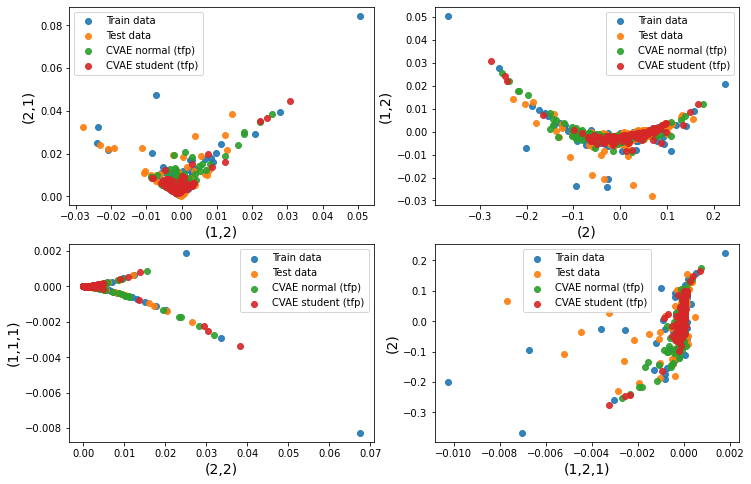

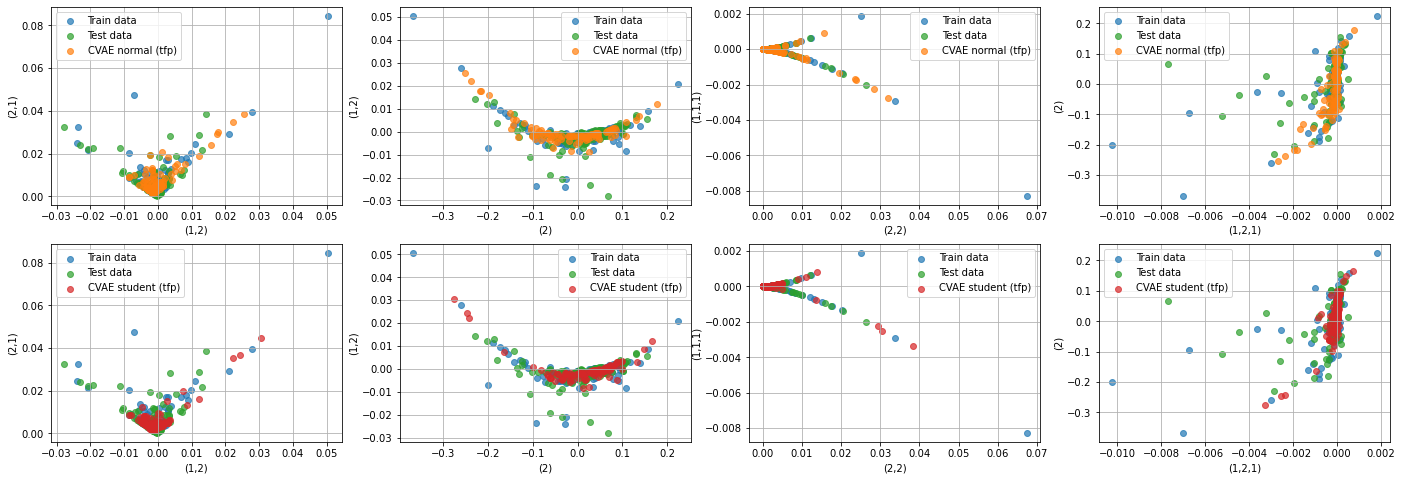

In [24]:
from esig.tosig import sigkeys
keys = sigkeys(2, order).split()
factor = []
for i in keys:
    factor.append((np.ceil((len(i)-2)/2)))
factor = np.array(factor)
PROJECTIONS = [(4, 5), (2, 4), (6, 7), (9, 2)]
# set_sig = [train_sig, test_sig, generated_sig, generated_sig1, generated_sig2]
# set_name = ["Train data", "Test data", "CVAE normal (keras)", "CVAE normal (tfp)", "CVAE student (tfp)"]
set_sig = [train_sig, test_sig, generated_sig1, generated_sig2]
set_name = ["Train data", "Test data", "CVAE normal (tfp)", "CVAE student (tfp)"]
plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i + 1)
    for j, signame in enumerate(zip(set_sig, set_name)):
        sig, name = signame
        plt.scatter(sig[:, projection[0]], sig[:, projection[1]],label=name, alpha = 0.9)
    plt.xlabel(keys[projection[0]], fontsize=14)
    plt.ylabel(keys[projection[1]], fontsize=14)
#     plt.xticks([])
#     plt.yticks([])
    plt.legend()
plt.show()

f,p=plt.subplots(2,4,figsize=(24,8))
for k, projection in enumerate(PROJECTIONS):
    for i in range(2):
        p[i,k].scatter(train_sig[:, projection[0]], train_sig[:, projection[1]],\
                       label="Train data", alpha = 0.7, color = 'tab:blue')
        p[i,k].scatter(test_sig[:, projection[0]], test_sig[:, projection[1]],\
                       label="Test data", alpha = 0.7, color = 'tab:green')
        if i == 0:
            p[i,k].scatter(generated_sig1[:, projection[0]], generated_sig1[:, projection[1]],\
                         label="CVAE normal (tfp)", alpha = 0.7, color = 'tab:orange')
        else: 
            p[i,k].scatter(generated_sig2[:, projection[0]], generated_sig2[:, projection[1]],\
                         label="CVAE student (tfp)", alpha = 0.7, color = 'tab:red')
        p[i,k].set_xlabel(keys[projection[0]], fontsize=10)
        p[i,k].set_ylabel(keys[projection[1]], fontsize=10)
        p[i,k].legend()
        p[i,k].grid()
plt.show()
#     plt.xticks([])
#     plt.yticks([])

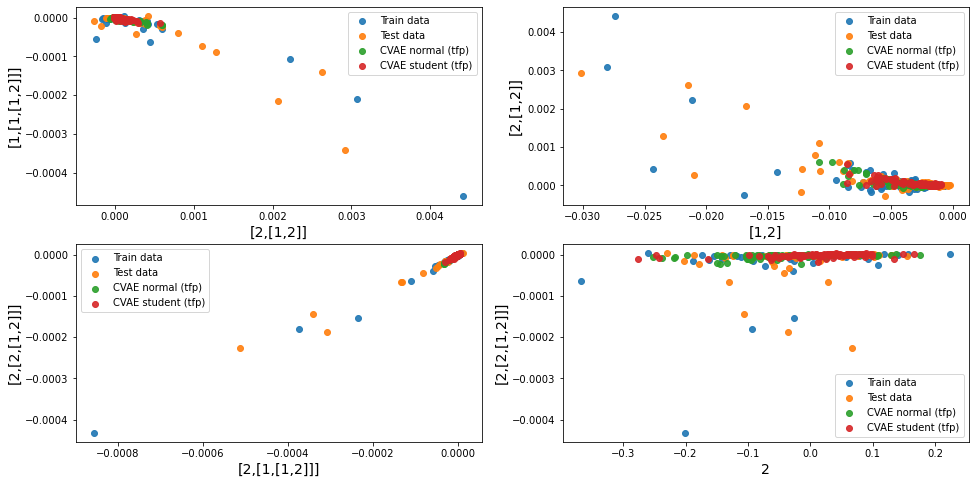

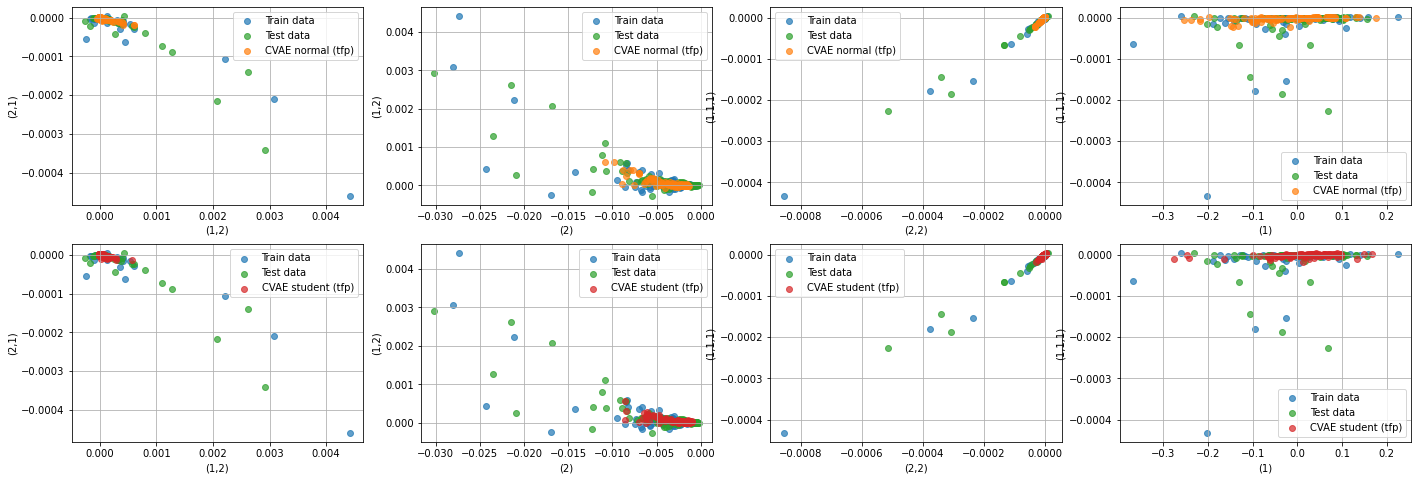

In [25]:
from esig.tosig import logsigkeys
import re

logkeys = logsigkeys(2, order).split()

logfactor = []
for i in logkeys:
    logfactor.append((len(re.sub("\D", "", i))))
logfactor = np.array(logfactor)

PROJECTIONS = [(4, 5), (2, 4), (6, 7), (1, 7)]

set_logsig = [train_logsig, test_logsig, generated_logsig1, generated_logsig2]
set_name = ["Train data", "Test data", "CVAE normal (tfp)", "CVAE student (tfp)"]

plt.figure(figsize=(16, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i+1)
    for sig, name in zip(set_logsig, set_name):
        plt.scatter(sig[:, projection[0]], sig[:, projection[1]],label=name, alpha = 0.9)
        
    plt.xlabel(logkeys[projection[0]], fontsize=14)
    plt.ylabel(logkeys[projection[1]], fontsize=14)
#     plt.xticks([])
#     plt.yticks([])
    plt.legend()
plt.show()

f,p=plt.subplots(2,4,figsize=(24,8))
for k, projection in enumerate(PROJECTIONS):
    for i in range(2):
        p[i,k].scatter(train_logsig[:, projection[0]], train_logsig[:, projection[1]],\
                       label="Train data", alpha = 0.7, color = 'tab:blue')
        p[i,k].scatter(test_logsig[:, projection[0]], test_logsig[:, projection[1]],\
                       label="Test data", alpha = 0.7, color = 'tab:green')
        if i == 0:
            p[i,k].scatter(generated_logsig1[:, projection[0]], generated_logsig1[:, projection[1]],\
                         label="CVAE normal (tfp)", alpha = 0.7, color = 'tab:orange')
        else: 
            p[i,k].scatter(generated_logsig2[:, projection[0]], generated_logsig2[:, projection[1]],\
                         label="CVAE student (tfp)", alpha = 0.7, color = 'tab:red')
        p[i,k].set_xlabel(keys[projection[0]], fontsize=10)
        p[i,k].set_ylabel(keys[projection[1]], fontsize=10)
        p[i,k].legend()
        p[i,k].grid()
plt.show()
#     plt.xticks([])
#     plt.yticks([])

## Evaluation

In [14]:
import evaluation
reload(evaluation)

import process_discriminator
reload(process_discriminator)

# phi1 = process_discriminator.T_global(test_sig[1:], generated_sig1,\
#                                      order=4, verbose=False, normalise=True, compute_sigs=False)
# phi2 = process_discriminator.T_global(test_sig[1:], generated_sig2,\
#                                      order=4, verbose=False, normalise=True, compute_sigs=False)
# phi = min(phi1,phi2)



windows1 = _load_rough_bergomi(params, 'M')
sig1 = np.array([_sig(path) for path in tqdm(windows1, desc="Computing signatures")])
windows2 = _load_rough_bergomi(params, 'M')
sig2 = np.array([_sig(path) for path in tqdm(windows2, desc="Computing signatures")])
phi, PHI_X, PHI_Y = process_discriminator.T_global(sig1, sig2, order=4, verbose=True, normalise=True, compute_sigs=False)
phi = min(np.array(PHI_X).mean(),np.array(PHI_Y).mean())
phi


0.2633351795770453


0.9203500258463402

In [15]:
TU0 = []
TU1 = []
TU2 = []
TU3 = []
for i in range(20):
    print(i)
    
    windows1 = _load_rough_bergomi(params, 'M')
    logsig1 = np.array([_logsig(path) for path in tqdm(windows1, desc="Computing log-signatures")])
    sig1 = np.array([_sig(path) for path in tqdm(windows1, desc="Computing signatures")])
    
    windows2 = _load_rough_bergomi(params, 'M')
    logsig2 = np.array([_logsig(path) for path in tqdm(windows2, desc="Computing log-signatures")])
    sig2 = np.array([_sig(path) for path in tqdm(windows2, desc="Computing signatures")])

    scaler_logsig1 = MinMaxScaler(feature_range=(0.00001, 0.99999))
    logsig_transformed1 = scaler_logsig.fit_transform(logsig1)

    scaler_sig1 = MinMaxScaler(feature_range=(0.00001, 0.99999))
    sig_transformed1 = scaler_sig.fit_transform(sig1)

    data1 = logsig_transformed1[1:]   # 1 week forecasting 1 week 
    data_cond1 = logsig_transformed1[:-1] 
    scaler1 = scaler_logsig1

    normalised_generated_normal = model_normal.generate(data_cond1)
    generated_logsig_normal = scaler.inverse_transform(normalised_generated_normal)
    generated_sig_normal = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated_logsig_normal)])

    normalised_generated_student = model_student.generate(data_cond1)
    generated_logsig_student = scaler.inverse_transform(normalised_generated_student)
    generated_sig_student = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated_logsig_student)])
    
    result, TU = process_discriminator.test_fix(sig1[1:], sig2[1:],\
                                                order=order, confidence_level=0.99, phi_x = phi, compute_sigs=False)
    TU0.append(TU)
    
    result, TU = process_discriminator.test_fix(sig1[1:], generated_sig_normal,\
                                                order=order, confidence_level=0.99, phi_x = phi, compute_sigs=False)
    TU1.append(TU)
    
    result, TU = process_discriminator.test_fix(sig1[1:], generated_sig_student,\
                                                order=order, confidence_level=0.99, phi_x = phi, compute_sigs=False)
    TU2.append(TU)
    
    different = tf.constant(_load_rough_bergomi(params2,'M'))
    
    
    result, TU = process_discriminator.test_fix(tf.constant(windows1), different, order=3, confidence_level=0.99, phi_x = phi)
    TU3.append(TU)
    

0



c: 0.04030256447915187
TU: 0.018433775408596365
m: 99



c: 0.04030256447915187
TU: 4.035733673240154
m: 99



c: 0.04030256447915187
TU: 4.554169036750765
m: 99



c: 0.040100545339935616
TU: 0.34650064938306135
m: 100
1



c: 0.04030256447915187
TU: 0.01733265967640696
m: 99



c: 0.04030256447915187
TU: 4.8176018241895395
m: 99



c: 0.04030256447915187
TU: 4.916550771086122
m: 99



c: 0.040100545339935616
TU: 0.2267662256577645
m: 100
2



c: 0.04030256447915187
TU: 0.01710304300193677
m: 99



c: 0.04030256447915187
TU: 3.6551158940244886
m: 99



c: 0.04030256447915187
TU: 3.805207800536805
m: 99



c: 0.040100545339935616
TU: 0.3266811750455707
m: 100
3



c: 0.04030256447915187
TU: 0.10004926895876931
m: 99



c: 0.04030256447915187
TU: 5.219428839921459
m: 99



c: 0.04030256447915187
TU: 5.43512286551913
m: 99



c: 0.040100545339935616
TU: 0.45452479067325235
m: 100
4



c: 0.04030256447915187
TU: 0.022511878062442925
m: 99



c: 0.04030256447915187
TU: 2.6658657738550975
m: 99



c: 0.04030256447915187
TU: 2.660793574849575
m: 99



c: 0.040100545339935616
TU: 0.3351533064418968
m: 100
5



c: 0.04030256447915187
TU: 0.021134363132313982
m: 99



c: 0.04030256447915187
TU: 4.378202674367903
m: 99



c: 0.04030256447915187
TU: 4.630735250322841
m: 99



c: 0.040100545339935616
TU: 0.2146615918937198
m: 100
6



c: 0.04030256447915187
TU: 0.002677219544905629
m: 99



c: 0.04030256447915187
TU: 1.777467456635276
m: 99



c: 0.04030256447915187
TU: 2.085937394353234
m: 99



c: 0.040100545339935616
TU: 0.3735806505956729
m: 100
7



c: 0.04030256447915187
TU: 0.010743176893034168
m: 99



c: 0.04030256447915187
TU: 4.865401395878661
m: 99



c: 0.04030256447915187
TU: 4.88908262862045
m: 99



c: 0.040100545339935616
TU: 0.23643421747803428
m: 100
8



c: 0.04030256447915187
TU: 0.018327464734971155
m: 99



c: 0.04030256447915187
TU: 4.471738990333436
m: 99



c: 0.04030256447915187
TU: 4.888378735225165
m: 99



c: 0.040100545339935616
TU: 0.2754777113013551
m: 100
9



c: 0.04030256447915187
TU: 0.011525380120279038
m: 99



c: 0.04030256447915187
TU: 5.513512964819525
m: 99



c: 0.04030256447915187
TU: 5.742417934639741
m: 99



c: 0.040100545339935616
TU: 0.1595199707417625
m: 100
10



c: 0.04030256447915187
TU: 0.014544918473746726
m: 99



c: 0.04030256447915187
TU: 5.819179150101237
m: 99



c: 0.04030256447915187
TU: 6.315984334722737
m: 99



c: 0.040100545339935616
TU: 0.1678938889231909
m: 100
11



c: 0.04030256447915187
TU: 0.04773847029892986
m: 99



c: 0.04030256447915187
TU: 4.956761145323078
m: 99



c: 0.04030256447915187
TU: 4.977343307399514
m: 99



c: 0.040100545339935616
TU: 0.18385469075894934
m: 100
12



c: 0.04030256447915187
TU: 0.021308958986388404
m: 99



c: 0.04030256447915187
TU: 4.3280437173701145
m: 99



c: 0.04030256447915187
TU: 5.22468227158457
m: 99



c: 0.040100545339935616
TU: 0.2624265739016671
m: 100
13



c: 0.04030256447915187
TU: 0.023407198166849774
m: 99



c: 0.04030256447915187
TU: 5.077646941543831
m: 99



c: 0.04030256447915187
TU: 5.5382143811475775
m: 99



c: 0.040100545339935616
TU: 0.24000718117286235
m: 100
14



c: 0.04030256447915187
TU: 0.007962434172878563
m: 99



c: 0.04030256447915187
TU: 3.5003313001450373
m: 99



c: 0.04030256447915187
TU: 4.125227391842241
m: 99



c: 0.040100545339935616
TU: 0.24714927007864862
m: 100
15



c: 0.04030256447915187
TU: 0.06802886631004057
m: 99



c: 0.04030256447915187
TU: 4.399022555128752
m: 99



c: 0.04030256447915187
TU: 4.67248970144311
m: 99



c: 0.040100545339935616
TU: 0.2556415371146912
m: 100
16



c: 0.04030256447915187
TU: 0.062316891211718684
m: 99



c: 0.04030256447915187
TU: 4.986960602383817
m: 99



c: 0.04030256447915187
TU: 5.109324933733951
m: 99



c: 0.040100545339935616
TU: 0.23925423192943418
m: 100
17



c: 0.04030256447915187
TU: 0.031126983237910633
m: 99



c: 0.04030256447915187
TU: 4.56914868493657
m: 99



c: 0.04030256447915187
TU: 5.070888519543164
m: 99



c: 0.040100545339935616
TU: 0.30933208893304753
m: 100
18



c: 0.04030256447915187
TU: 0.03982405250251375
m: 99



c: 0.04030256447915187
TU: 3.425098736608266
m: 99



c: 0.04030256447915187
TU: 3.8727231090223944
m: 99



c: 0.040100545339935616
TU: 0.34114231747718193
m: 100
19



c: 0.04030256447915187
TU: 0.015548411911276983
m: 99



c: 0.04030256447915187
TU: 5.071399634293728
m: 99



c: 0.04030256447915187
TU: 5.333530240801522
m: 99



c: 0.040100545339935616
TU: 0.17749465547567667
m: 100


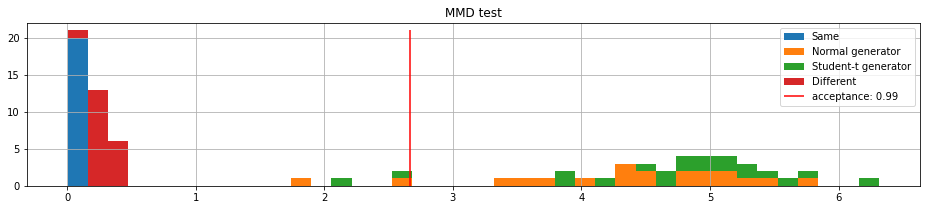

In [27]:
K = 8
m = 100
alpha = 0.5
split = 4*K / np.sqrt(m) * np.sqrt(np.log(1/alpha))

TU = np.array([TU0, TU1, TU2, TU3])
label = ['Same', 'Normal generator', 'Student-t generator', 'Different'] 
plt.figure(figsize = (16,3))
a = plt.hist(TU.T, bins = 40, histtype='bar', stacked=True, label = label)
plt.vlines(split,0,a[0].max(), color = 'r', label = 'acceptance: 0.99')
plt.legend()
plt.grid()
plt.title('MMD test')
# plt.ylabel('$T_{U}^{2}"$')
plt.show()

## From Signature to Path

In [28]:
import logsig_inversion
from esig.tosig import stream2logsig
from utils.leadlag import leadlag
from gpsig import kernels
import gpflow

In [29]:
# pip = 0.001
# n_pips = 5 * 10
# n_points = 28
# n_iterations = 100
# n_organisms = 100
# recovered_paths = []
# for i, logsig in enumerate(generated):
#     recovered_paths.append(logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points, pip, n_pips)[0] + 1.)
    

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import signatory
import base
import neural_inverse
from importlib import reload
import time as timing
reload(neural_inverse)

<module 'neural_inverse' from '../src\\neural_inverse.py'>

In [63]:
reload(neural_inverse)
N = 28 - 1 
path = np.array(train_windows)[:,::2,0]
path = path[:,:,None]
time = np.linspace(0,1,N+1)
time_torch = np.tile(time[None,:,None],[100,1,1])
time_torch = torch.Tensor(time_torch)
order = 4
path = np.array([np.concatenate([time[:,None],path0],axis = -1) for path0 in path])

logsig = signatory.logsignature(torch.tensor(path), order)
net, y_recover, logsig_recover = neural_inverse.inverse_multiple_path_time(logsig, N, order, time_torch, 1)

step:  0 loss:  0.39297888427972794
step:  100 loss:  0.0009103245683945715
step:  200 loss:  0.000507373726577498
step:  300 loss:  0.00030902604339644313
step:  400 loss:  0.00022145264665596187
step:  500 loss:  0.0001762831561791245
step:  600 loss:  0.00012920578228658997
step:  700 loss:  0.00011872796676470898
step:  800 loss:  0.00011102714779553935
step:  900 loss:  0.001671155358053511
Finished Training


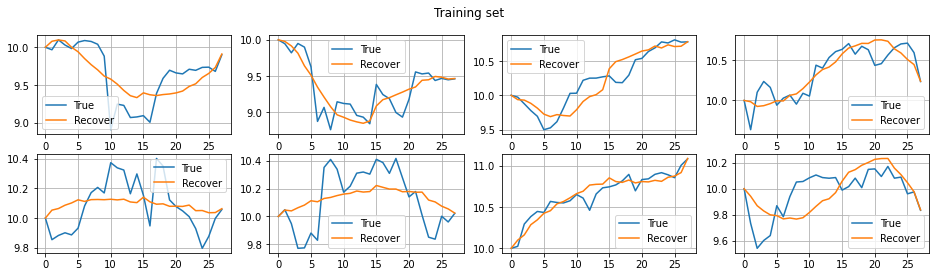

In [64]:
f,p=plt.subplots(2,4,figsize=(16,4)) 
for i in range(2):
    for j in range(4):
        idx = np.random.randint(0,100)
        
        p[i,j].plot(path[idx,:,-1], label = 'True')
        p[i,j].plot(y_recover[idx,:,-1] + 10, label = 'Recover')
        p[i,j].grid()
        p[i,j].legend()
plt.suptitle('Training set')
plt.show()